<a href="https://colab.research.google.com/github/andreamaurizi/Synthetic-generation-of-anomaly-data/blob/main/synthetic_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.hub import load_state_dict_from_url

from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary

from PIL import Image
from torch.utils.data import Dataset
import numpy as np

from typing import Callable, Optional, Union, Sequence

from torch.utils.data import DataLoader

import os
import random



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = os.path.join("drive", "MyDrive", "Canopies-data")
DEVICE = torch.device("cpu")
print(DEVICE)

torch.manual_seed(42)

Mounted at /content/drive
cpu


# Scala 2

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np



# Folder path containing the images
folder_path = '/content/drive/MyDrive/Canopies-data/good-patches/scale_2/'

# Get a list of all image files in the folder (ignoring .txt files)
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Create an empty array to store the images
image_array = []

# Display the first ten images and add them to the array
for i in range(min(500, len(image_files))):
    # Construct the full path to the image
    image_path = os.path.join(folder_path, image_files[i])

    # Load the image
    img = cv2.imread(image_path)

    # Display the image using Matplotlib
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.title(f'Image {i + 1}: {image_files[i]}')
    #plt.show()

    # Add the image to the array
    image_array.append(img)

# Convert the list to a numpy array
image_array = np.array(image_array)



In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches/scale_2'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization
    normal = cv2.divide(gray, blur, scale=255)

    # stretch to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # filter out small contours and fit ellipse
    result_img = image.copy()
    i = 1
    # Initialize mask outside the loop
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 10000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area with dark purple
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]  # Adjust these values for your desired dark purple

            blended_roi = roi * ones











            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True

            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img





for j in range(min(500, len(image_files))):
  print("Image:",j)
  image1 = colorTryAndSave(2.1,0.9,2.3,image_array[j],j)




Now let's try different colors!

In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches-varied/scale_2'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization to enhance local contrast
    normal = cv2.divide(gray, blur, scale=255)

    # stretch the intensity values to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphological closing operation to the thresholded image to fill gaps and smooth edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # initialize variables for processing contours and create a mask for blending
    result_img = image.copy()
    i = 1
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False
    # iterate over each contour, filtering out small ones based on area
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 10000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]

            # Create a mask with ones at the specified indices to represent the dark purple color
            blended_roi = roi * ones












            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True

            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img






for j in range(min(500, len(image_files))):
  print("Image:",j)
  if (j % 2 == 0):
    # Generate random values for each color channel within the specified ranges
    blue_value = random.uniform(0.5, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(2, 2.5)  # range: 0 to 1
  else:
    blue_value = random.uniform(2, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(0.5, 2.5)  # range: 0 to 1

  # Randomly select one of the predefined colors
  random_color = (blue_value, green_value, red_value)

  # Pass the randomly generated color to the colorTryAndSave function
  image1 = colorTryAndSave(random_color[0], random_color[1], random_color[2], image_array[j], j)





#Scala 1.5

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np



# Folder path containing the images
folder_path = '/content/drive/MyDrive/Canopies-data/good-patches/scale_1.5/'

# Get a list of all image files in the folder (ignoring .txt files)
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Create an empty array to store the images
image_array = []

# Display the first ten images and add them to the array
for i in range(min(500, len(image_files))):
    # Construct the full path to the image
    image_path = os.path.join(folder_path, image_files[i])

    # Load the image
    img = cv2.imread(image_path)

    # Display the image using Matplotlib
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.title(f'Image {i + 1}: {image_files[i]}')
    #plt.show()

    # Add the image to the array
    image_array.append(img)

# Convert the list to a numpy array
image_array = np.array(image_array)



In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches/scale_1.5'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization
    normal = cv2.divide(gray, blur, scale=255)

    # stretch to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # filter out small contours and fit ellipse
    result_img = image.copy()
    i = 1
    # Initialize mask outside the loop
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 10000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area with dark purple
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]  # Adjust these values for your desired dark purple

            blended_roi = roi * ones











            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True
            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img





for j in range(min(500, len(image_files))):
  print("Image:",j)
  image1 = colorTryAndSave(2.1,0.9,2.3,image_array[j],j)




Let's try different colors!

In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches-varied/scale_1.5'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization to enhance local contrast
    normal = cv2.divide(gray, blur, scale=255)

    # stretch the intensity values to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphological closing operation to the thresholded image to fill gaps and smooth edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # initialize variables for processing contours and create a mask for blending
    result_img = image.copy()
    i = 1
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False
    # iterate over each contour, filtering out small ones based on area
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 10000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]

            # Create a mask with ones at the specified indices to represent the dark purple color
            blended_roi = roi * ones












            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True

            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img






for j in range(min(500, len(image_files))):
  print("Image:",j)
  if (j % 2 == 0):
    # Generate random values for each color channel within the specified ranges
    blue_value = random.uniform(0.5, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(2, 2.5)  # range: 0 to 1
  else:
    blue_value = random.uniform(2, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(0.5, 2.5)  # range: 0 to 1

  # Randomly select one of the predefined colors
  random_color = (blue_value, green_value, red_value)

  # Pass the randomly generated color to the colorTryAndSave function
  image1 = colorTryAndSave(random_color[0], random_color[1], random_color[2], image_array[j], j)





#Scala 1

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np



# Folder path containing the images
folder_path = '/content/drive/MyDrive/Canopies-data/good-patches/scale_1/'

# Get a list of all image files in the folder (ignoring .txt files)
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Create an empty array to store the images
image_array = []

# Display the first ten images and add them to the array
for i in range(min(500, len(image_files))):
    # Construct the full path to the image
    image_path = os.path.join(folder_path, image_files[i])

    # Load the image
    img = cv2.imread(image_path)

    # Display the image using Matplotlib
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.title(f'Image {i + 1}: {image_files[i]}')
    #plt.show()

    # Add the image to the array
    image_array.append(img)

# Convert the list to a numpy array
image_array = np.array(image_array)



In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches/scale_1'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization
    normal = cv2.divide(gray, blur, scale=255)

    # stretch to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # filter out small contours and fit ellipse
    result_img = image.copy()
    i = 1
    # Initialize mask outside the loop
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False

    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 5000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area with dark purple
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]  # Adjust these values for your desired dark purple

            blended_roi = roi * ones











            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True
            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img





for j in range(min(500, len(image_files))):
  print("Image:",j)
  image1 = colorTryAndSave(2.1,0.9,2.3,image_array[j],j)




Let's try different colors!

Image: 0
Image: 1
Image is out of bounds
Contour 1 - Relative Area: 0.9188
Image: 2
Image: 3
Image is out of bounds
Contour 1 - Relative Area: 0.6929
Image: 4
Contour 1 - Relative Area: 0.6670


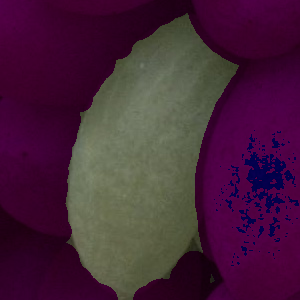

Image: 5
Image: 6
Contour 1 - Relative Area: 0.9822


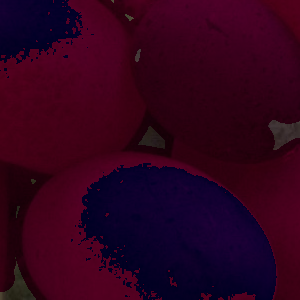

Image: 7
Image: 8
Image: 9
Contour 1 - Relative Area: 0.9862


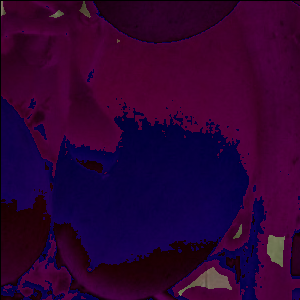

Image: 10
Image: 11
Image: 12
Image: 13
Image: 14
Image: 15
Image: 16
Image: 17
Image: 18
Image: 19
Image: 20
Image: 21
Image: 22
Image is out of bounds
Contour 1 - Relative Area: 0.9773
Image: 23
Image: 24
Image: 25
Image: 26
Image: 27
Image: 28
Image: 29
Image: 30
Contour 1 - Relative Area: 0.8189


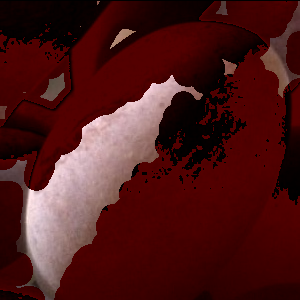

Image: 31
Image: 32
Image: 33
Image: 34
Contour 1 - Relative Area: 0.9735


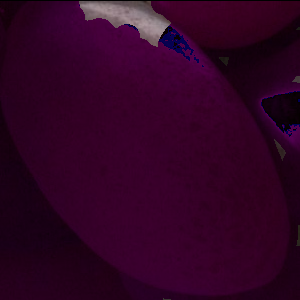

Image: 35
Image: 36
Image: 37
Image: 38
Image is out of bounds
Contour 1 - Relative Area: 0.9362
Image: 39
Image: 40
Image: 41
Image: 42
Image: 43
Image: 44
Image: 45
Image: 46
Image: 47
Image is out of bounds
Contour 1 - Relative Area: 0.9093
Image: 48
Image: 49
Image: 50
Image: 51
Image: 52
Image: 53
Image: 54
Image: 55
Image: 56
Image is out of bounds
Contour 1 - Relative Area: 0.9342
Image: 57
Contour 1 - Relative Area: 0.9749


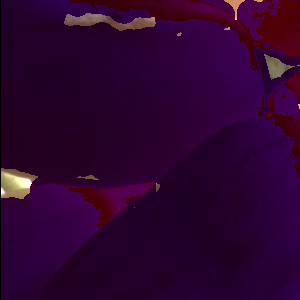

Image: 58
Image: 59
Image: 60
Contour 1 - Relative Area: 0.7305


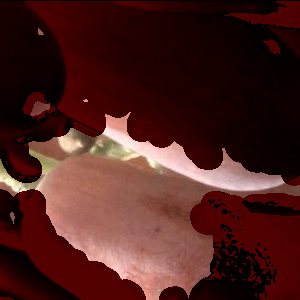

Image: 61
Image is out of bounds
Contour 1 - Relative Area: 0.9761
Image: 62
Image: 63
Image is out of bounds
Contour 1 - Relative Area: 0.8787
Image: 64
Image: 65
Image: 66
Image: 67
Image is out of bounds
Contour 1 - Relative Area: 0.9757
Image: 68
Image: 69
Image: 70
Image: 71
Image is out of bounds
Contour 1 - Relative Area: 0.9835
Image: 72
Image: 73
Contour 1 - Relative Area: 0.7553


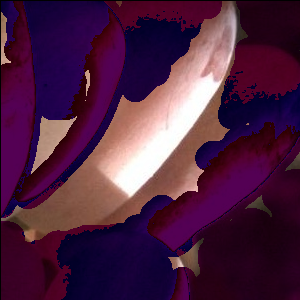

Image: 74
Image: 75
Image: 76
Image: 77
Image: 78
Image is out of bounds
Contour 1 - Relative Area: 0.7146
Image: 79
Image: 80
Image: 81
Image is out of bounds
Contour 1 - Relative Area: 0.9016
Image: 82
Contour 1 - Relative Area: 0.9552


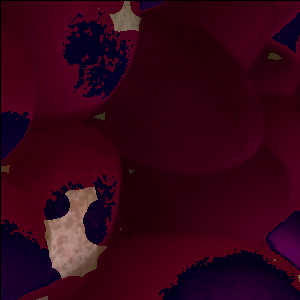

Image: 83
Image: 84
Image: 85
Image: 86
Image is out of bounds
Contour 1 - Relative Area: 0.7997
Image: 87
Image: 88
Image: 89
Image: 90
Image: 91
Image: 92
Image: 93
Image: 94
Contour 1 - Relative Area: 0.9421


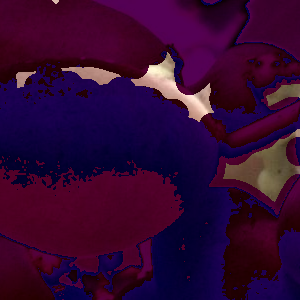

Image: 95
Contour 1 - Relative Area: 0.8958


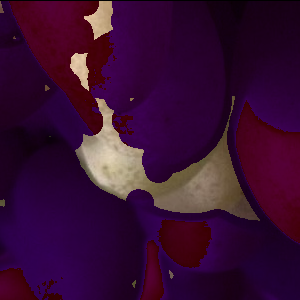

Image: 96
Contour 1 - Relative Area: 0.9537


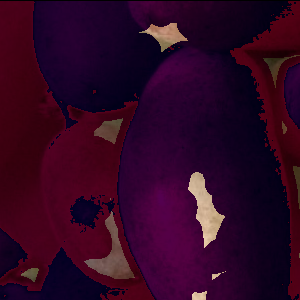

Image: 97
Image: 98
Image is out of bounds
Contour 1 - Relative Area: 0.9146
Image: 99
Image: 100
Image: 101
Image is out of bounds
Contour 1 - Relative Area: 0.9432
Image: 102
Image: 103
Image is out of bounds
Contour 1 - Relative Area: 0.9902
Image: 104
Image is out of bounds
Contour 1 - Relative Area: 0.9489
Image: 105
Image: 106
Image: 107
Image: 108
Image: 109
Image: 110
Image: 111
Image: 112
Image: 113
Image: 114
Image is out of bounds
Contour 1 - Relative Area: 0.9658
Image: 115
Image: 116
Image is out of bounds
Contour 1 - Relative Area: 0.9618
Image: 117
Image is out of bounds
Contour 1 - Relative Area: 0.9517
Image: 118
Image: 119
Image: 120
Image: 121
Image: 122
Image: 123
Image: 124
Image: 125
Contour 1 - Relative Area: 0.8441


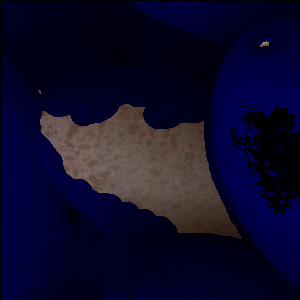

Image: 126
Image: 127
Image: 128
Image: 129
Image is out of bounds
Contour 1 - Relative Area: 0.9296
Image: 130
Contour 1 - Relative Area: 0.6910


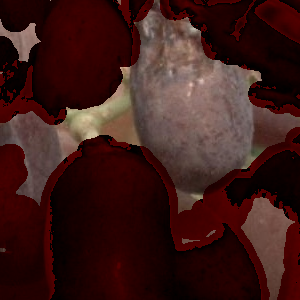

Image: 131
Image: 132
Image: 133
Image is out of bounds
Contour 1 - Relative Area: 0.9807
Image: 134
Image: 135
Image is out of bounds
Contour 1 - Relative Area: 0.7147
Image: 136
Image is out of bounds
Contour 1 - Relative Area: 0.9060
Image: 137
Image is out of bounds
Contour 1 - Relative Area: 0.8887
Image: 138
Contour 1 - Relative Area: 0.7821


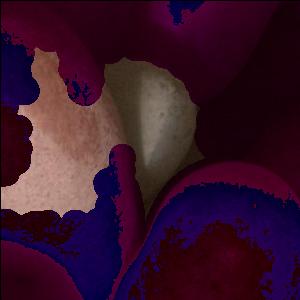

Image: 139
Contour 1 - Relative Area: 0.8971


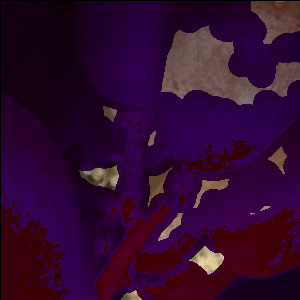

Image: 140
Image: 141
Image is out of bounds
Contour 1 - Relative Area: 0.9067
Image is out of bounds
Contour 2 - Relative Area: 0.9611
Image: 142
Image is out of bounds
Contour 1 - Relative Area: 0.9644
Image: 143
Image is out of bounds
Contour 1 - Relative Area: 0.9103
Image is out of bounds
Contour 2 - Relative Area: 0.6235
Image: 144
Image is out of bounds
Contour 1 - Relative Area: 0.9713
Image: 145
Image: 146
Image: 147
Image: 148
Image: 149
Contour 1 - Relative Area: 0.8511


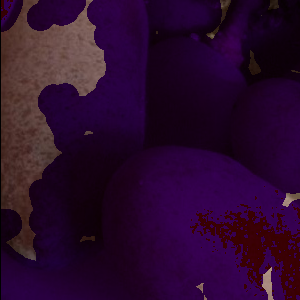

Image: 150
Image: 151
Image is out of bounds
Contour 1 - Relative Area: 0.9324
Image: 152
Image is out of bounds
Contour 1 - Relative Area: 0.7253
Image: 153
Image is out of bounds
Contour 1 - Relative Area: 0.9898
Image: 154
Contour 1 - Relative Area: 0.8961


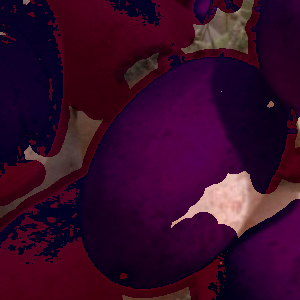

Image: 155
Image: 156
Contour 1 - Relative Area: 0.8242


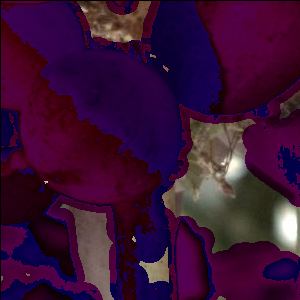

Image: 157
Image is out of bounds
Contour 1 - Relative Area: 0.8976
Image: 158
Image: 159
Image is out of bounds
Contour 1 - Relative Area: 0.8958
Image: 160
Image is out of bounds
Contour 1 - Relative Area: 0.8725
Image: 161
Image: 162
Image: 163
Image: 164
Image: 165
Image: 166
Image is out of bounds
Contour 1 - Relative Area: 0.8661
Image: 167
Contour 1 - Relative Area: 0.8797


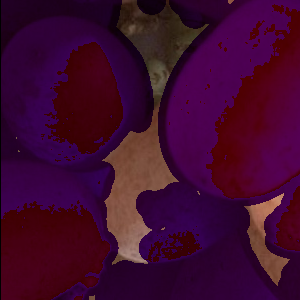

Image: 168
Image: 169
Image: 170
Image: 171
Image is out of bounds
Contour 1 - Relative Area: 0.9707
Image: 172
Image: 173
Image: 174
Image is out of bounds
Contour 1 - Relative Area: 0.9701
Image: 175
Image: 176
Image is out of bounds
Contour 1 - Relative Area: 0.9750
Image: 177
Image is out of bounds
Contour 1 - Relative Area: 0.9560
Image: 178
Image: 179
Contour 1 - Relative Area: 0.9371


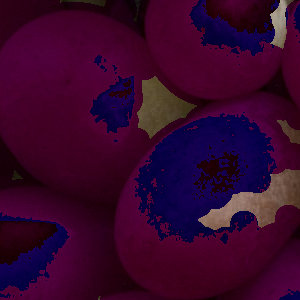

Image: 180
Image is out of bounds
Contour 1 - Relative Area: 0.9646
Image: 181
Image: 182
Image is out of bounds
Contour 1 - Relative Area: 0.9515
Image: 183
Contour 1 - Relative Area: 0.9536


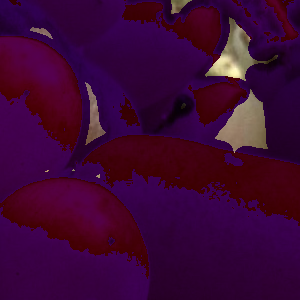

Image: 184
Image is out of bounds
Contour 1 - Relative Area: 0.8563
Image: 185
Image: 186
Image: 187
Image: 188
Image is out of bounds
Contour 1 - Relative Area: 0.9366
Image: 189
Image: 190
Contour 1 - Relative Area: 0.9375


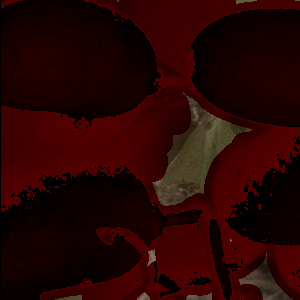

Image: 191
Image is out of bounds
Contour 1 - Relative Area: 0.9681
Image: 192
Image: 193
Contour 1 - Relative Area: 0.9424


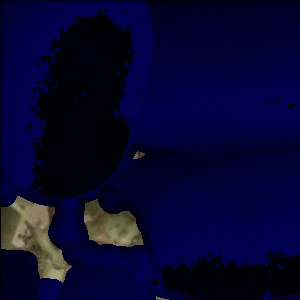

Image: 194
Contour 1 - Relative Area: 0.8604


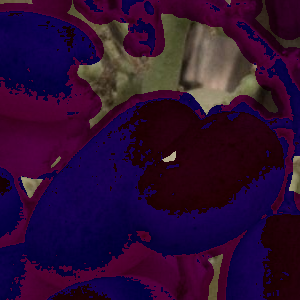

Image: 195
Contour 1 - Relative Area: 0.7426


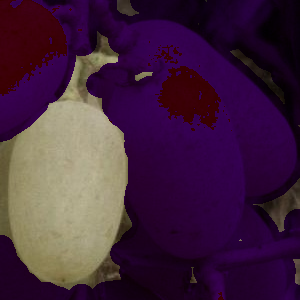

Image: 196
Image: 197
Contour 1 - Relative Area: 0.9603


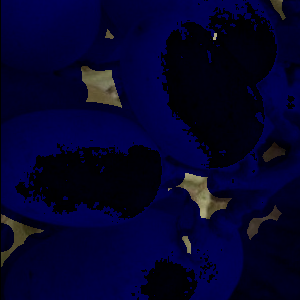

Image: 198
Image: 199
Image is out of bounds
Contour 1 - Relative Area: 0.8216
Image: 200
Contour 1 - Relative Area: 0.9882


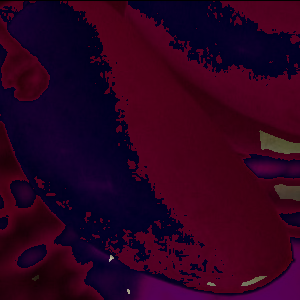

Image: 201
Contour 1 - Relative Area: 0.9117


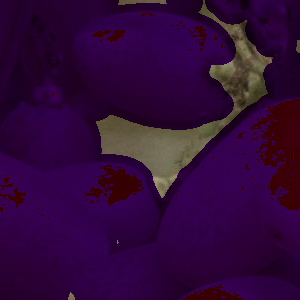

Image: 202
Image: 203
Image: 204
Image: 205
Contour 1 - Relative Area: 0.9777


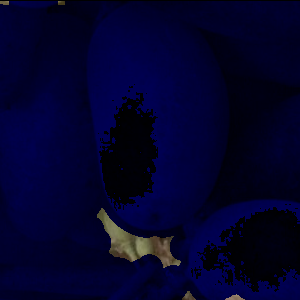

Image: 206
Image: 207
Image: 208
Image: 209
Image: 210
Image: 211
Image: 212
Image: 213
Image: 214
Image: 215
Image: 216
Image: 217
Image: 218
Image: 219
Image: 220
Image: 221
Image: 222
Image: 223
Image: 224
Image: 225
Contour 1 - Relative Area: 0.9910


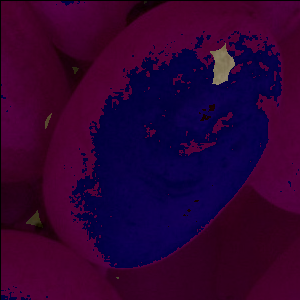

Image: 226
Image is out of bounds
Contour 1 - Relative Area: 0.9138
Image: 227
Image is out of bounds
Contour 1 - Relative Area: 0.9260
Image: 228
Image: 229
Image: 230
Image: 231
Image: 232
Image: 233
Image: 234
Image is out of bounds
Contour 1 - Relative Area: 0.7378
Image: 235
Image: 236
Image: 237
Contour 1 - Relative Area: 0.9643


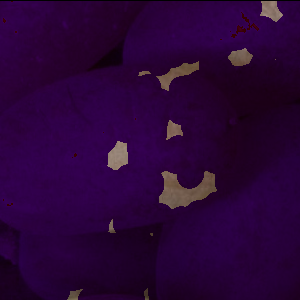

Image: 238
Contour 1 - Relative Area: 0.8704


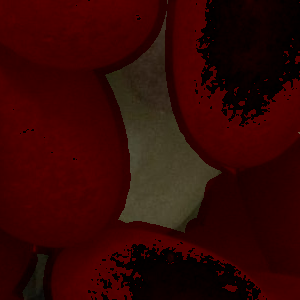

Image: 239
Image: 240
Contour 1 - Relative Area: 0.9843


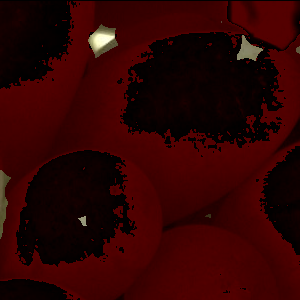

Image: 241
Image: 242
Image is out of bounds
Contour 1 - Relative Area: 0.6368
Image: 243
Contour 1 - Relative Area: 0.7582


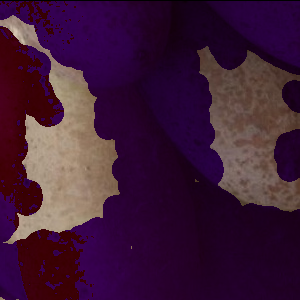

Image: 244
Image: 245
Contour 1 - Relative Area: 0.6763


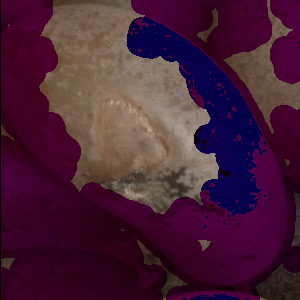

Image: 246
Image: 247
Contour 1 - Relative Area: 0.8456


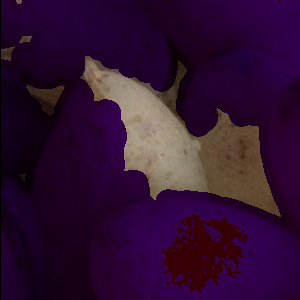

Image: 248
Contour 1 - Relative Area: 0.9373


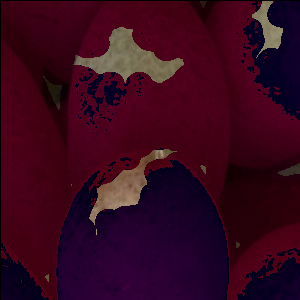

Image: 249
Image: 250
Contour 1 - Relative Area: 0.7628


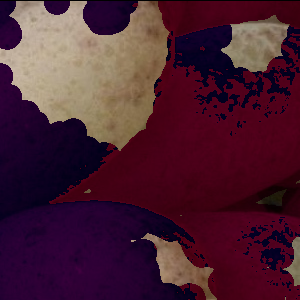

Image: 251
Image: 252
Image is out of bounds
Contour 1 - Relative Area: 0.9591
Image: 253
Contour 1 - Relative Area: 0.9655


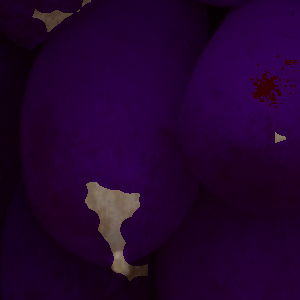

Image: 254
Image: 255
Image is out of bounds
Contour 1 - Relative Area: 0.9606
Image: 256
Image: 257
Contour 1 - Relative Area: 0.7866


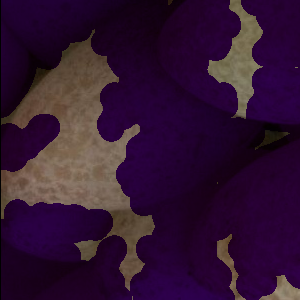

Image: 258
Image: 259
Image: 260
Contour 1 - Relative Area: 0.9459


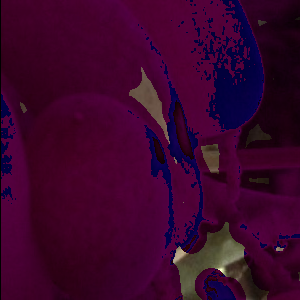

Image: 261
Image: 262
Image is out of bounds
Contour 1 - Relative Area: 0.7973
Image: 263
Image: 264
Image: 265
Image: 266
Contour 1 - Relative Area: 0.9378


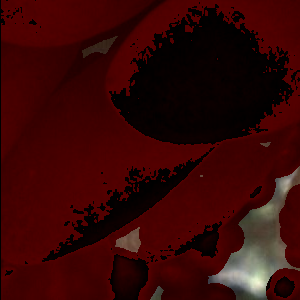

Image: 267
Image is out of bounds
Contour 1 - Relative Area: 0.7787
Image: 268
Image is out of bounds
Contour 1 - Relative Area: 0.9189
Image: 269
Image: 270
Image: 271
Image: 272
Image: 273
Image: 274
Image is out of bounds
Contour 1 - Relative Area: 0.9655
Image: 275
Contour 1 - Relative Area: 0.9982


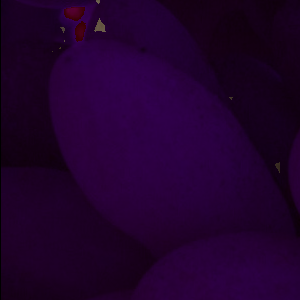

Image: 276
Contour 1 - Relative Area: 0.7137


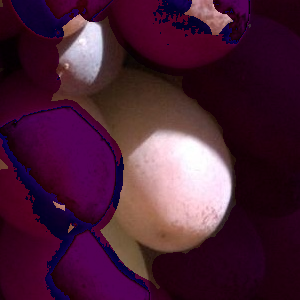

Image: 277
Image: 278
Image: 279
Contour 1 - Relative Area: 0.6457


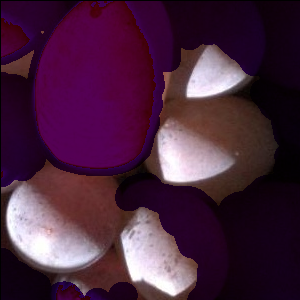

Image: 280
Image: 281
Image: 282
Image: 283
Contour 1 - Relative Area: 0.7595


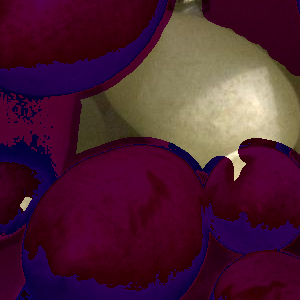

Image: 284
Image: 285
Image: 286
Contour 1 - Relative Area: 0.7171


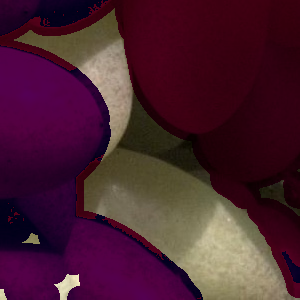

Image: 287
Image: 288
Image: 289
Image: 290
Contour 1 - Relative Area: 0.9873


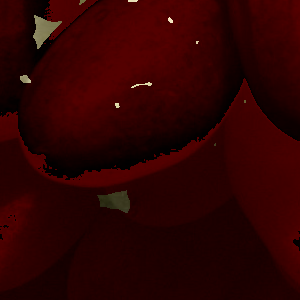

Image: 291
Image: 292
Image: 293
Contour 1 - Relative Area: 0.8392


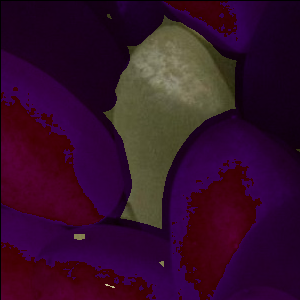

Image: 294
Image: 295
Image is out of bounds
Contour 1 - Relative Area: 0.9570
Image: 296
Contour 1 - Relative Area: 0.8785


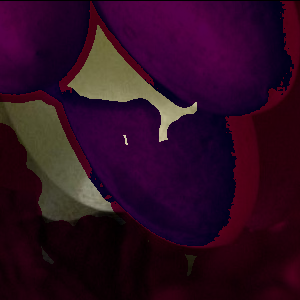

Image: 297
Image: 298
Image: 299
Image is out of bounds
Contour 1 - Relative Area: 0.8297
Image: 300
Contour 1 - Relative Area: 0.8918


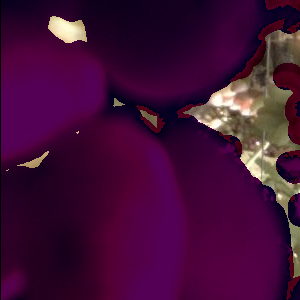

Image: 301
Contour 1 - Relative Area: 0.9517


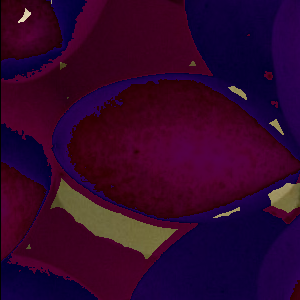

Image: 302
Contour 1 - Relative Area: 0.8023


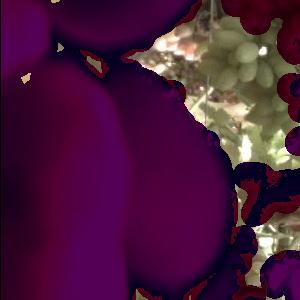

Image: 303
Image: 304
Image is out of bounds
Contour 1 - Relative Area: 0.9539
Image: 305
Contour 1 - Relative Area: 0.9791
Image is out of bounds
Contour 2 - Relative Area: 0.9321
Image: 306
Image: 307
Image: 308
Image: 309
Image: 310
Image: 311
Image: 312
Image: 313
Image: 314
Image: 315
Image: 316
Image: 317
Image: 318
Image: 319
Image: 320
Contour 1 - Relative Area: 0.9351


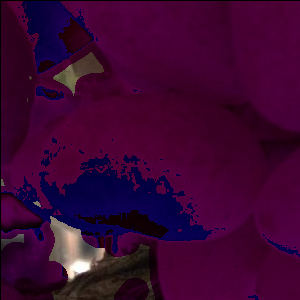

Image: 321
Image is out of bounds
Contour 1 - Relative Area: 0.9734
Image: 322
Image: 323
Image: 324
Image is out of bounds
Contour 1 - Relative Area: 0.9515
Image: 325
Image: 326
Image: 327
Image: 328
Image: 329
Image: 330
Image: 331
Image is out of bounds
Contour 1 - Relative Area: 0.7060
Image: 332
Contour 1 - Relative Area: 0.6330


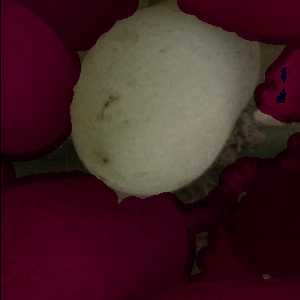

Image: 333
Image: 334
Contour 1 - Relative Area: 0.9700


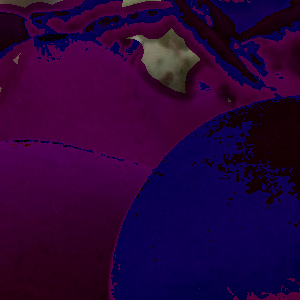

Image: 335
Image: 336
Image: 337
Contour 1 - Relative Area: 0.9718


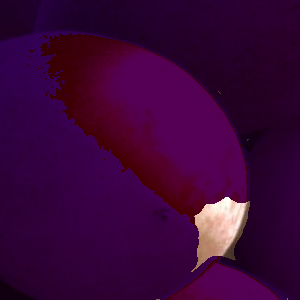

Image: 338
Image: 339
Image: 340
Image: 341
Image: 342
Image: 343
Image: 344
Image: 345
Image: 346
Image: 347
Image: 348
Image: 349
Image: 350
Image: 351
Image is out of bounds
Contour 1 - Relative Area: 0.8439
Image: 352
Image is out of bounds
Contour 1 - Relative Area: 0.9390
Image: 353
Image: 354
Image is out of bounds
Contour 1 - Relative Area: 0.8595
Image: 355
Image: 356
Contour 1 - Relative Area: 0.9615


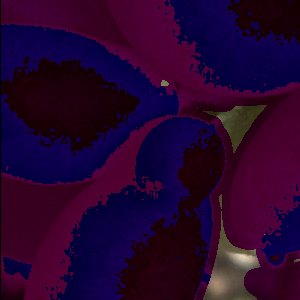

Image: 357
Image is out of bounds
Contour 1 - Relative Area: 0.9005
Image: 358
Image is out of bounds
Contour 1 - Relative Area: 0.7262
Image: 359
Image: 360
Image is out of bounds
Contour 1 - Relative Area: 0.9016
Image: 361
Image: 362
Image: 363
Image: 364
Contour 1 - Relative Area: 0.9618


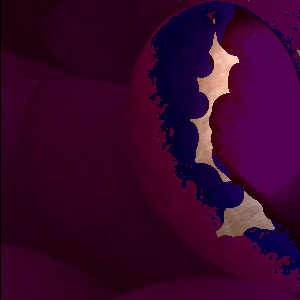

Image: 365
Contour 1 - Relative Area: 0.7021


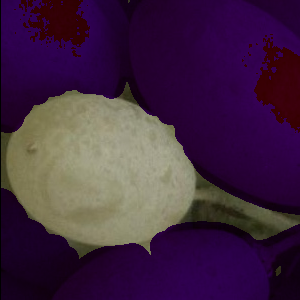

Image: 366
Contour 1 - Relative Area: 0.9485


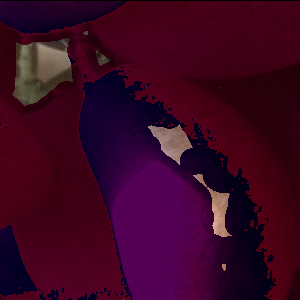

Image: 367
Image: 368
Image: 369
Image: 370
Contour 1 - Relative Area: 0.9758


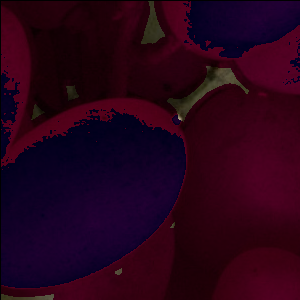

Image: 371
Contour 1 - Relative Area: 0.6266


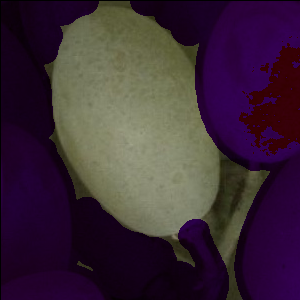

Image: 372
Image is out of bounds
Contour 1 - Relative Area: 0.9160
Image: 373
Image is out of bounds
Contour 1 - Relative Area: 0.9457
Image: 374
Image: 375
Image: 376
Image is out of bounds
Contour 1 - Relative Area: 0.8423
Image: 377
Contour 1 - Relative Area: 0.6866


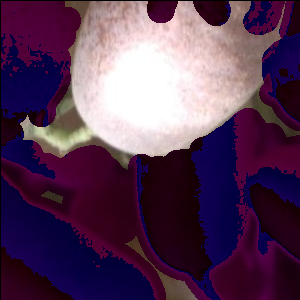

Image: 378
Contour 1 - Relative Area: 0.9875


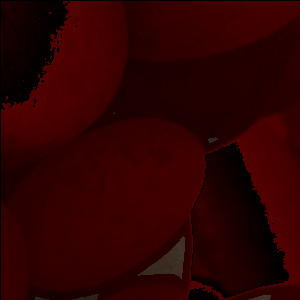

Image: 379
Contour 1 - Relative Area: 0.9517


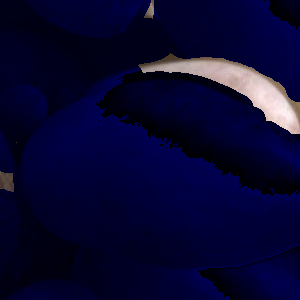

Image: 380
Image: 381
Image: 382
Image is out of bounds
Contour 1 - Relative Area: 0.9331
Image: 383
Image: 384
Contour 1 - Relative Area: 0.8783


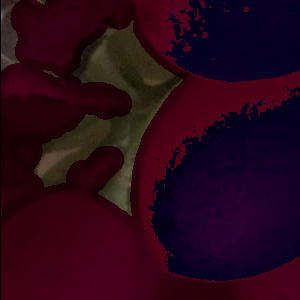

Image: 385
Image: 386
Image: 387
Image is out of bounds
Contour 1 - Relative Area: 0.8494
Image: 388
Image: 389
Contour 1 - Relative Area: 0.9757


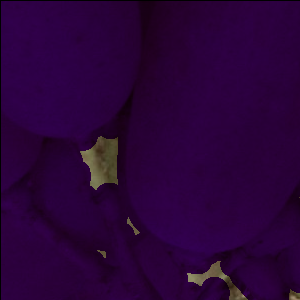

Image: 390
Image: 391
Contour 1 - Relative Area: 0.6974


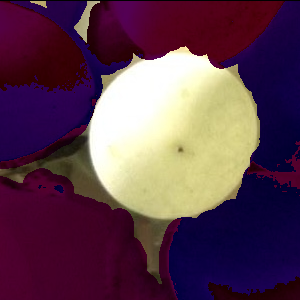

Image: 392
Image: 393
Image: 394
Image: 395
Image is out of bounds
Contour 1 - Relative Area: 0.9383
Image: 396
Contour 1 - Relative Area: 0.9916


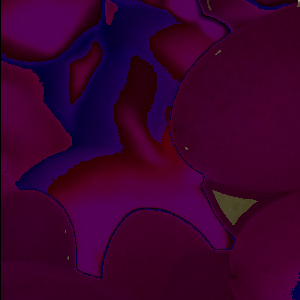

Image: 397
Image: 398
Image: 399
Contour 1 - Relative Area: 0.9371


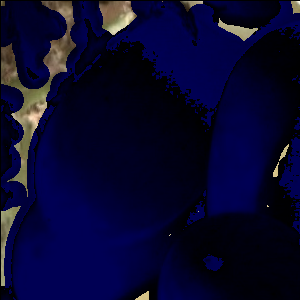

Image: 400
Image is out of bounds
Contour 1 - Relative Area: 0.9118
Image: 401
Image is out of bounds
Contour 1 - Relative Area: 0.9716
Image: 402
Image: 403
Image: 404
Image: 405
Image: 406
Contour 1 - Relative Area: 0.9399


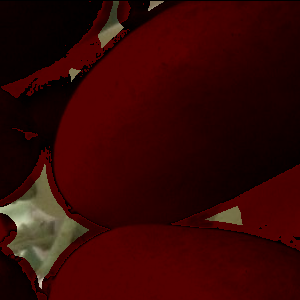

Image: 407
Image is out of bounds
Contour 1 - Relative Area: 0.8778
Image: 408
Image: 409
Image: 410
Image: 411
Image: 412
Image: 413
Image: 414
Image: 415
Image: 416
Image: 417
Image: 418
Image: 419
Image: 420
Image is out of bounds
Contour 1 - Relative Area: 0.8850
Image: 421
Image: 422
Image: 423
Contour 1 - Relative Area: 0.8343


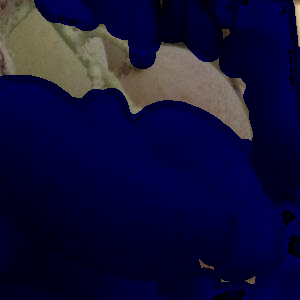

Image: 424
Image: 425
Image: 426
Image is out of bounds
Contour 1 - Relative Area: 0.9085
Image: 427
Image: 428
Image: 429
Image: 430
Image: 431
Image is out of bounds
Contour 1 - Relative Area: 0.9222
Image: 432
Image: 433
Image: 434
Image: 435
Image: 436
Image: 437
Image: 438
Image: 439
Image: 440
Image: 441
Image: 442
Contour 1 - Relative Area: 0.9558


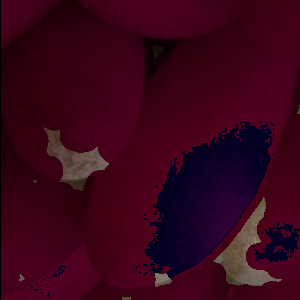

Image: 443
Image: 444
Contour 1 - Relative Area: 0.7904


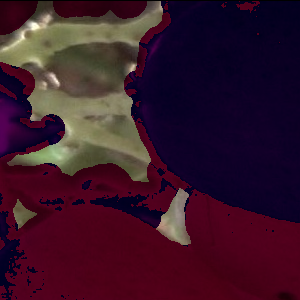

Image: 445
Image: 446
Contour 1 - Relative Area: 0.9991


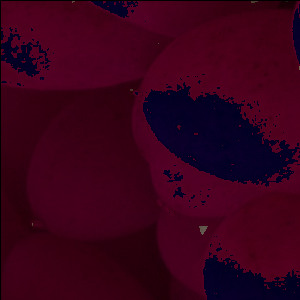

Image: 447
Image is out of bounds
Contour 1 - Relative Area: 0.9113
Image: 448
Image: 449
Image: 450
Image: 451
Image: 452
Image: 453
Contour 1 - Relative Area: 0.9341


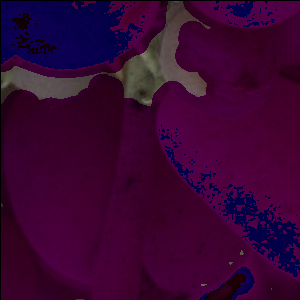

Image: 454
Image is out of bounds
Contour 1 - Relative Area: 0.9853
Image: 455
Image: 456
Image: 457
Image: 458
Contour 1 - Relative Area: 0.7919


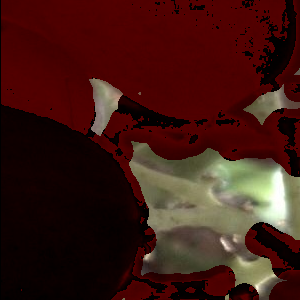

Image: 459
Image: 460
Contour 1 - Relative Area: 0.6938


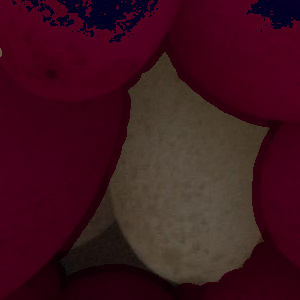

Image: 461
Image: 462
Image: 463
Image: 464
Image: 465
Image: 466
Image is out of bounds
Contour 1 - Relative Area: 0.9285
Image: 467
Image: 468
Image: 469
Contour 1 - Relative Area: 0.6513


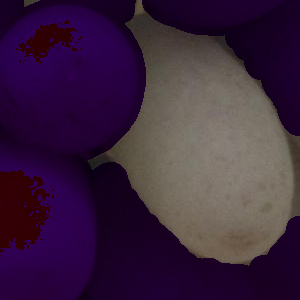

Image: 470
Image is out of bounds
Contour 1 - Relative Area: 0.9674
Image: 471
Image: 472
Image: 473
Image: 474
Image: 475
Contour 1 - Relative Area: 0.9094


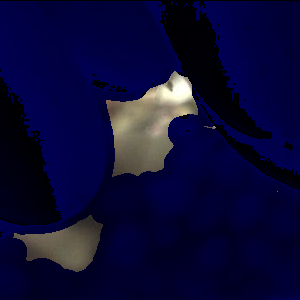

Image: 476
Image: 477
Image: 478
Image: 479
Contour 1 - Relative Area: 0.9524


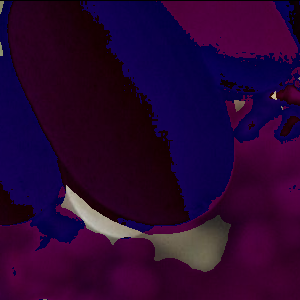

Image: 480
Image is out of bounds
Contour 1 - Relative Area: 0.9859
Image: 481
Image: 482
Image: 483
Image: 484
Image is out of bounds
Contour 1 - Relative Area: 0.9800
Image: 485
Image: 486
Image: 487
Image: 488
Image: 489
Image: 490
Contour 1 - Relative Area: 0.8176


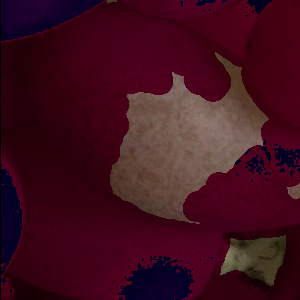

Image: 491
Image: 492
Image: 493
Contour 1 - Relative Area: 0.9301


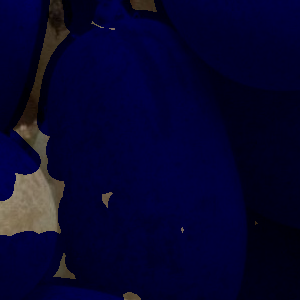

Image: 494
Image: 495
Image is out of bounds
Contour 1 - Relative Area: 0.9451
Image is out of bounds
Contour 2 - Relative Area: 0.9047
Image: 496
Image: 497
Image: 498
Image is out of bounds
Contour 1 - Relative Area: 0.8335
Image: 499


In [ ]:
import skimage.exposure
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
import math

# Specify the Google Drive folder path
output_folder_path = '/content/drive/MyDrive/Canopies-data/synthetic-sick-patches-varied/scale_1'






def random_rotate(image):


    # Define rotation angles
    rotation_angles = [0, 90, 180, 270]

    # Randomly choose a rotation angle
    random_angle = random.choice(rotation_angles)

    # Perform rotation
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows))

    return rotated_img





def colorTryAndSave(blue, green, red, image, image_number):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=99, sigmaY=99)

    # do division normalization to enhance local contrast
    normal = cv2.divide(gray, blur, scale=255)

    # stretch the intensity values to full dynamic range
    stretch = skimage.exposure.rescale_intensity(normal, in_range='image', out_range=(0,255)).astype(np.uint8)

    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 6)

    # apply morphological closing operation to the thresholded image to fill gaps and smooth edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # initialize variables for processing contours and create a mask for blending
    result_img = image.copy()
    i = 1
    mask = np.zeros_like(img)
    outOfBounds = False
    areaRatioEnough = False
    # iterate over each contour, filtering out small ones based on area
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 10000:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(cntr)

            # Create a mask for the filled area
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [cntr], 0, (255, 255, 255), thickness=cv2.FILLED)

            # Invert the mask
            mask_inv_not_blurred = cv2.bitwise_not(mask)


            # Apply Gaussian blur to the inverted mask for smoothing
            mask_inv = cv2.GaussianBlur(mask_inv_not_blurred , (17, 17), 0)

            # Extract the region of interest from the original image
            roi = image[y:y + h, x:x + w]





            # Apply the provided code to fill the inverted area
            a = np.where(mask_inv > 0)

            # Ensure indices are within bounds
            valid_indices = (a[0] < roi.shape[0]) & (a[1] < roi.shape[1])
            a = (a[0][valid_indices], a[1][valid_indices])

            if not np.all(valid_indices):
              outOfBounds = True
            if outOfBounds:
              print(f"Image is out of bounds")


            ones = np.ones_like(roi)
            ones[a[0], a[1], :] = [blue , green, red]

            # Create a mask with ones at the specified indices to represent the dark purple color
            blended_roi = roi * ones












            # Replace the region in the result image with the blended ROI
            result_img[y:y + h, x:x + w] = blended_roi

            result_img[a] //=3



            # Convert mask_inv to single-channel (grayscale)
            mask_inv_gray = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2GRAY)


            # Calculate the area of mask_inv relative to the size of the whole picture
            total_image_area = img.shape[0] * img.shape[1]
            mask_inv_area = cv2.countNonZero(mask_inv_gray)
            area_ratio = mask_inv_area / total_image_area
            if area_ratio > 0.5:
                areaRatioEnough = True

            print(f"Contour {i} - Relative Area: {area_ratio:.4f}")

            i = i + 1

    # Display the result




    if not outOfBounds and areaRatioEnough:
      #cv2_imshow(mask)

      result_img = random_rotate(result_img )
      cv2_imshow(result_img)
      # Save the result image to Google Drive
      output_filename = f'synthetic_image_{image_number}.png'
      output_path = os.path.join(output_folder_path, output_filename)
      cv2.imwrite(output_path, result_img)


    return result_img






for j in range(min(500, len(image_files))):
  print("Image:",j)
  if (j % 2 == 0):
    # Generate random values for each color channel within the specified ranges
    blue_value = random.uniform(0.5, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(2, 2.5)  # range: 0 to 1
  else:
    blue_value = random.uniform(2, 2.5)  # range: 0 to 1
    green_value = random.uniform(0, 0.8)  # range: 1 to 2.5
    red_value = random.uniform(0.5, 2.5)  # range: 0 to 1

  # Randomly select one of the predefined colors
  random_color = (blue_value, green_value, red_value)

  # Pass the randomly generated color to the colorTryAndSave function
  image1 = colorTryAndSave(random_color[0], random_color[1], random_color[2], image_array[j], j)



